In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# from collections import defaultdict


# Directories

INPUT_DIR = 'in'
OUTPUT_DIR = 'out'
PLOT_DIR = f'{OUTPUT_DIR}/plots/'

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

In [ ]:
df = pd.read_csv(f"{INPUT_DIR}/43311-0002_de.csv",  delimiter=';')


# Fill missing Jahr & Monat
df["Jahr"].fillna(method="ffill", inplace=True)
df["Monat"].fillna(method="ffill", inplace=True)
df["Jahr"] = df["Jahr"].astype(int)

# Convert production columns to numeric
df["Elektrizitätserzeugung (brutto)"] = pd.to_numeric(df["Elektrizitätserzeugung (brutto)"], errors='coerce')
df["Elektrizitätserzeugung (netto)"] = pd.to_numeric(df["Elektrizitätserzeugung (netto)"], errors='coerce')

# Group by Jahr and Typ 
strommix_df = df.groupby(["Jahr", "Typ"])[["Elektrizitätserzeugung (netto)"]].sum().reset_index()

strommix_df.head(20)

C:\Users\sulta\AppData\Local\Temp\ipykernel_11792\3184133533.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Jahr"].fillna(method="ffill", inplace=True)
C:\Users\sulta\AppData\Local\Temp\ipykernel_11792\3184133533.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Monat"].fillna(method="ffill", inplace=True)


,Jahr,Typ,Elektrizitätserzeugung (netto)
0,2002,"Abfall (Hausmüll, Industrie)",2926818.0
1,2002,"Abfall (Hausmüll, Siedlungsabfälle)",0.0
2,2002,Abfall (Industrie),0.0
3,2002,Andere Speicher,0.0
4,2002,Biogas,30547.0
5,2002,Biomethan (Bioerdgas),0.0
6,2002,Braunkohlenbriketts,41935.0
7,2002,Braunkohlenkoks,0.0
8,2002,Deponiegas,110551.0
9,2002,Dieselkraftstoff,6381.0


In [134]:
import pandas as pd

# CSV einlesen
df_saldo = pd.read_csv(f"{INPUT_DIR}/43312-0002_de_flat.csv", sep=";")

# Filter: Deutschland insgesamt + Insgesamt
df_saldo_filtered = df_saldo[
    (df_saldo["2_variable_attribute_label"] == "Deutschland") &
    (df_saldo["3_variable_attribute_label"] == "Insgesamt") 
]

# Parse numbers
df_saldo_filtered["Jahr"] = df_saldo_filtered["time"].astype(int)
df_saldo_filtered["value"] = pd.to_numeric(
    df_saldo_filtered["value"]
    .astype(str)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False),
    errors="coerce"
)

# Group: Jahr + Typ und Werte summieren
grouped = (
    df_saldo_filtered
    .groupby(["Jahr", "value_variable_label"])["value"]
    .sum()
    .reset_index()
)

grouped = grouped.rename(columns={
    "value_variable_label": "Typ",
    "value": "Elektrizitätserzeugung (netto)"
})

# Timeframe: 2002–2024
austauschsaldo = grouped[(grouped["Jahr"] >= 2002) & (grouped["Jahr"] <= 2024)]

# austauschsaldo.head(20)

# Concat export data
strommix_gesamt = pd.concat([strommix_df, austauschsaldo], ignore_index=True)

# Tipp: Typen ggf. von überflüssigen Leerzeichen befreien (hast du unten schon gemerkt)
strommix_gesamt["Typ"] = strommix_gesamt["Typ"].str.strip()

# 'Insgesamt' rausfiltern FIXME remove
# strommix_gesamt = strommix_gesamt[strommix_gesamt["Typ"] != "Insgesamt"]

# Test output
strommix_gesamt[strommix_gesamt["Jahr"] == 2022].sort_values("Jahr")

C:\Users\sulta\AppData\Local\Temp\ipykernel_11792\1984715857.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saldo_filtered["Jahr"] = df_saldo_filtered["time"].astype(int)
C:\Users\sulta\AppData\Local\Temp\ipykernel_11792\1984715857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saldo_filtered["value"] = pd.to_numeric(


,Jahr,Typ,Elektrizitätserzeugung (netto)
1040,2022,"Abfall (Hausmüll, Industrie)",0.0
1069,2022,Pumpspeicher mit natürlichem Zufluss,458795.0
1070,2022,Pumpspeicher ohne natürlichen Zufluss,0.0
1071,2022,Pumpspeicherwasser,0.0
1072,2022,Raffineriegas,0.0
1073,2022,Rohbraunkohlen,105943522.0
1074,2022,Solarthermie,0.0
1075,2022,Sonstige Braunkohlen,0.0
1076,2022,Sonstige Energieträger,0.0
1077,2022,Sonstige Mineralölprodukte,0.0


In [ ]:
# Wind / Solar energie import

import json

# Load JSON file
with open(f"{INPUT_DIR}/bruttostromerzeugung-energieträger.json", "r", encoding="utf-8") as f:
    brutto_data = json.load(f)

# Existing years in the database
valid_years = set(strommix_gesamt["Jahr"].unique())

# Extract only Windkraft and Photovoltaik entries
zusatz_daten = {
    "Windkraft": brutto_data.get("Wind", {}),
    "Photovoltaik": brutto_data.get("Photovoltaik", {})
}

# Collect valid records
records = []
for typ, jahresdaten in zusatz_daten.items():
    for jahr, value in jahresdaten.items():
        try:
            jahr_int = int(jahr)
            if jahr_int in valid_years and value and value.strip():
                value_float = float(value.replace(",", "."))
                records.append({
                    "Jahr": jahr_int,
                    "Typ": typ,
                    "Elektrizitätserzeugung (netto)": value_float * 1_000_000  # TWh -> MWh
                })
        except ValueError:
            continue  # skip malformed entries

df_zusatz = pd.DataFrame(records)

# Remove existing entries for these types to avoid duplicates and concat data
strommix_gesamt = strommix_gesamt[
    ~strommix_gesamt["Typ"].isin(["Windkraft", "Photovoltaik"])
]
strommix_gesamt = pd.concat([strommix_gesamt, df_zusatz], ignore_index=True)

# Json is missing 2024 data
zusatz_2024 = pd.DataFrame([
    {"Jahr": 2024, "Typ": "Windkraft", "Elektrizitätserzeugung (netto)": 138_900_000},
    {"Jahr": 2024, "Typ": "Photovoltaik", "Elektrizitätserzeugung (netto)": 74_100_000}
])

strommix_gesamt = pd.concat([strommix_gesamt, zusatz_2024], ignore_index=True)

# Check result
strommix_gesamt[strommix_gesamt["Typ"].isin(["Windkraft", "Photovoltaik"])].sort_values(["Typ", "Jahr"])



,Jahr,Typ,Elektrizitätserzeugung (netto)
1218,2002,Photovoltaik,200000.0
1219,2003,Photovoltaik,300000.0
1220,2004,Photovoltaik,600000.0
1221,2005,Photovoltaik,1300000.0
1222,2006,Photovoltaik,2200000.0
1223,2007,Photovoltaik,3100000.0
1224,2008,Photovoltaik,4400000.0
1225,2009,Photovoltaik,6600000.0
1226,2010,Photovoltaik,11700000.0
1227,2011,Photovoltaik,19600000.0


In [135]:
# Check: Jährliche Summe der Elektrizitätserzeugung (netto) #### FIXME move or think about it, do we wanna show anything about this?, would be good tbh
jahres_summen = strommix_gesamt.groupby("Jahr")["Elektrizitätserzeugung (netto)"].sum().reset_index()

# MWh -> TWh 
jahres_summen["Elektrizität (TWh)"] = jahres_summen["Elektrizitätserzeugung (netto)"] / 1_000_000

jahres_summen = jahres_summen[["Jahr", "Elektrizität (TWh)"]].sort_values("Jahr")
display(jahres_summen)


,Jahr,Elektrizität (TWh)
0,2002,1070.270900
1,2003,1094.518712
2,2004,1094.006717
3,2005,1108.749110
4,2006,1106.784139
5,2007,1068.645007
6,2008,1060.503506
7,2009,983.936098
8,2010,1031.201651
9,2011,972.723826


In [42]:
# Mapping
typ_to_category = {
    # Fossile Brennstoffe
    "Braunkohlenbriketts": "Braunkohle",
    "Braunkohlenkoks": "Braunkohle",
    "Rohbraunkohlen": "Braunkohle",
    "Sonstige Braunkohlen": "Braunkohle",
    "Hartbraunkohlen": "Braunkohle",

    "Steinkohlen": "Steinkohle",
    "Steinkohlenbriketts": "Steinkohle",
    "Steinkohlenkoks": "Steinkohle",
    "Kohlenwertstoffe aus Steinkohle": "Steinkohle",
    "Sonstige Steinkohlen": "Steinkohle",
    "Staub- und Trockenkohle": "Steinkohle",
    "Wirbelschichtkohle": "Steinkohle",

    "Dieselkraftstoff": "Mineralöl",
    "Heizöl, leicht": "Mineralöl",
    "Heizöl, schwer": "Mineralöl",
    "Petrolkoks": "Mineralöl",
    "Raffineriegas": "Mineralöl",
    "Sonstige Mineralölprodukte": "Mineralöl",

    "Erdgas, Erdölgas": "Erdgas",
    "Flüssiggas": "Erdgas",

    "Hochofengas": "Industriegas",
    "Kokereigas": "Industriegas",
    "Sonstige hergestellte Gase": "Industriegas",

    # Erneuerbare
    "Photovoltaik": "Solar",
    "Solarthermie": "Solar",

    "Laufwasser": "Wasserkraft",
    "Pumpspeicherwasser": "Wasserkraft",
    "Pumpspeicher mit natürlichem Zufluss": "Wasserkraft",
    "Pumpspeicher ohne natürlichen Zufluss": "Wasserkraft",
    "Speicherwasser": "Wasserkraft",

    "Windkraft": "Wind",

    "Feste biogene Stoffe": "Biomasse",
    "Flüssige biogene Stoffe": "Biomasse",
    "Biogas": "Biomasse",
    "Biomethan (Bioerdgas)": "Biomasse",
    "Deponiegas": "Biomasse",
    "Klärgas": "Biomasse",
    "Klärschlamm": "Biomasse",
    "Grubengas": "Biomasse",

    "Geothermie": "Geothermie",
    "Wärmepumpen (Erd- und Umweltwärme)": "Geothermie",

    "Sonstige erneuerbare Energien": "Andere Erneuerbare",

    # Abfall
    "Abfall (Hausmüll, Industrie)": "Abfall",
    "Abfall (Hausmüll, Siedlungsabfälle)": "Abfall",
    "Abfall (Industrie)": "Abfall",

    # import / export
    "Einfuhr von Elektrizität": "Import",
    "Ausfuhr von Elektrizität": "Export",


    # Sonstige
    "Kernenergie": "Kernenergie",

    "Austauschsaldo": "Import/Export",

    "Strom (Elektrokessel)": "Sonstiges",
    "Andere Speicher": "Sonstiges",
    "Wasserstoff": "Wasserstoff", # todo make it be it's own category
    "Wärme": "Sonstiges",
    "Sonstige Energieträger": "Sonstiges",

    #
    "Insgesamt": "SUMME"
}

strommix_gesamt["Kategorie"] = strommix_gesamt["Typ"].map(typ_to_category).fillna("Unbekannt")

# Unbekannte debugging
# unbekannte_typen = strommix_gesamt[strommix_gesamt["Kategorie"] == "Unbekannt"]["Typ"].unique()
# pd.DataFrame({"Unbekannte Typen": sorted(unbekannte_typen)})

# TL Categories
TOP_LEVEL_CATEGORIES = sorted(set(typ_to_category.values()))
print(TOP_LEVEL_CATEGORIES)




strommix_gesamt[strommix_gesamt['Jahr'] == 2002].sort_values('Kategorie')



['Abfall', 'Andere Erneuerbare', 'Biomasse', 'Braunkohle', 'Erdgas', 'Export', 'Geothermie', 'Import', 'Import/Export', 'Industriegas', 'Kernenergie', 'Mineralöl', 'SUMME', 'Solar', 'Sonstiges', 'Steinkohle', 'Wasserkraft', 'Wasserstoff', 'Wind']


,Jahr,Typ,Elektrizitätserzeugung (netto),Kategorie
0,2002,"Abfall (Hausmüll, Industrie)",2926818.0,Abfall
1,2002,"Abfall (Hausmüll, Siedlungsabfälle)",0.0,Abfall
2,2002,Abfall (Industrie),0.0,Abfall
37,2002,Sonstige erneuerbare Energien,243469.0,Andere Erneuerbare
4,2002,Biogas,30547.0,Biomasse
5,2002,Biomethan (Bioerdgas),0.0,Biomasse
8,2002,Deponiegas,110551.0,Biomasse
22,2002,Klärschlamm,51438.0,Biomasse
11,2002,Feste biogene Stoffe,201651.0,Biomasse
12,2002,Flüssige biogene Stoffe,0.0,Biomasse


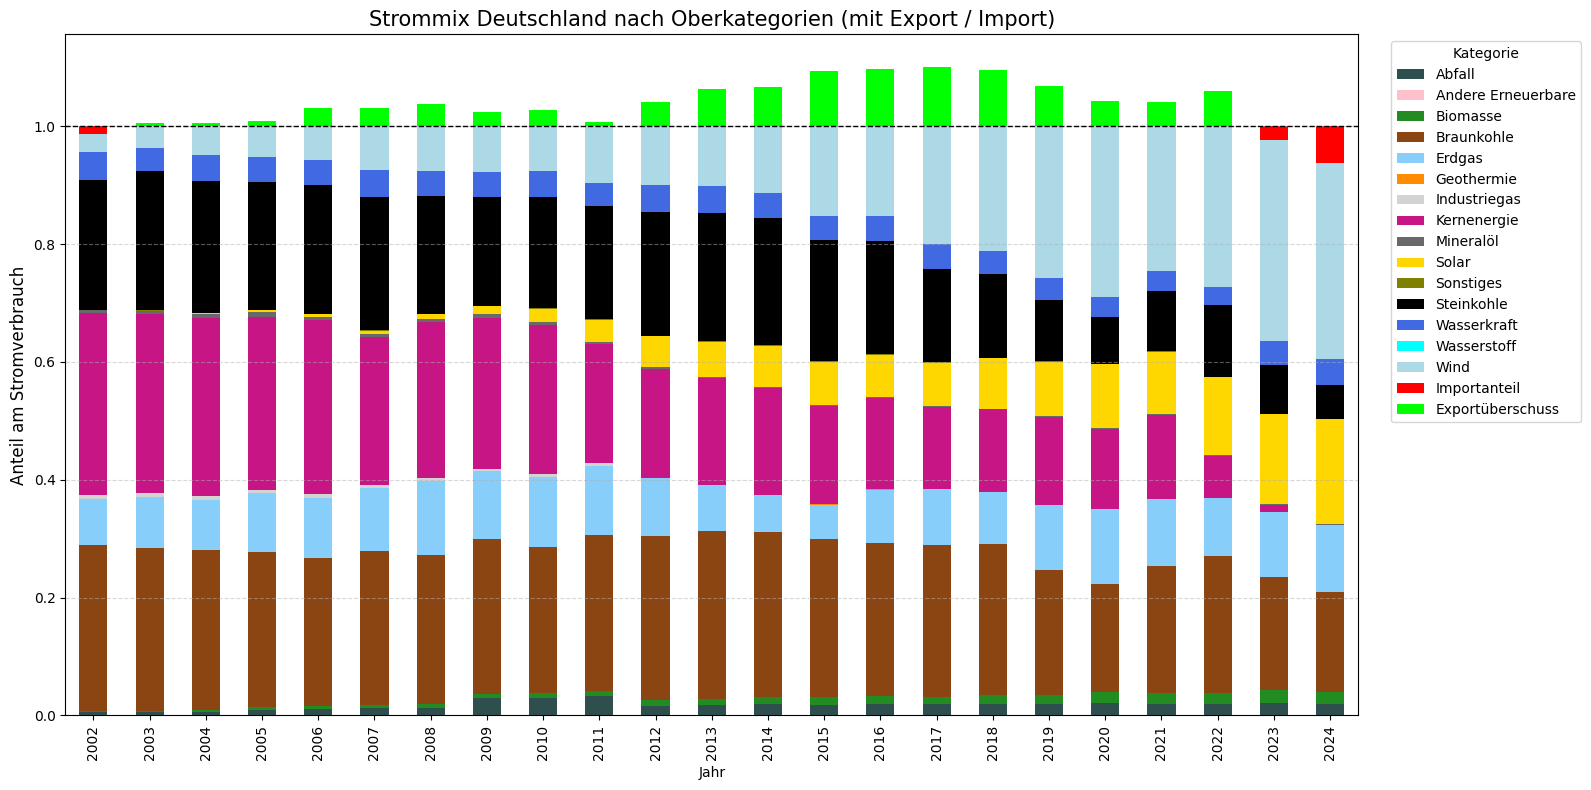

In [80]:
df_clean = strommix_gesamt[
    ~strommix_gesamt["Typ"].isin(["Einfuhr von Elektrizität", "Ausfuhr von Elektrizität"])
    & (strommix_gesamt["Typ"] != "Insgesamt")
]

# Summe aller Typen (ohne Austauschsaldo)
produktion = df_clean[df_clean["Typ"] != "Austauschsaldo"]
produktion_summe = produktion.groupby("Jahr")["Elektrizitätserzeugung (netto)"].sum().reset_index()
produktion_summe = produktion_summe.rename(columns={"Elektrizitätserzeugung (netto)": "Inlandsproduktion"})

# Austauschsaldo (positiv = Import, negativ = Export)
saldo = df_clean[df_clean["Typ"] == "Austauschsaldo"][["Jahr", "Elektrizitätserzeugung (netto)"]]
saldo = saldo.rename(columns={"Elektrizitätserzeugung (netto)": "Austauschsaldo"})

# Zusammenführen
basis = produktion_summe.merge(saldo, on="Jahr", how="left").fillna(0)

# Berechne Kategorie-Anteile (inkl. Import!)
produktion_rel = produktion.merge(basis, on="Jahr")
produktion_rel["Anteil"] = produktion_rel["Elektrizitätserzeugung (netto)"] / (
    produktion_rel["Inlandsproduktion"] + produktion_rel["Austauschsaldo"].clip(lower=0)
)

# Gruppieren nach Kategorie
produktion_kat = produktion_rel.groupby(["Jahr", "Kategorie"])["Anteil"].sum().reset_index()

# Importanteil (innerhalb der 100%)
import_df = basis[basis["Austauschsaldo"] > 0].copy()
import_df["Anteil"] = import_df["Austauschsaldo"] / (import_df["Inlandsproduktion"] + import_df["Austauschsaldo"])
import_df["Kategorie"] = "Importanteil"

# Exportüberschuss (oberhalb der 100%)
export_df = basis[basis["Austauschsaldo"] < 0].copy()
export_df["Anteil"] = -export_df["Austauschsaldo"] / export_df["Inlandsproduktion"]
export_df["Kategorie"] = "Exportüberschuss"

# Zusammenführen für den Plot
df_plot_ready = pd.concat([
    produktion_kat[["Jahr", "Kategorie", "Anteil"]],
    import_df[["Jahr", "Kategorie", "Anteil"]],
    export_df[["Jahr", "Kategorie", "Anteil"]],
])

# Pivot + Sortierung: Exportüberschuss zuletzt
pivot_plot = df_plot_ready.pivot_table(
    index="Jahr",
    columns="Kategorie",
    values="Anteil",
    aggfunc="sum"
).fillna(0)

# Export & Import ans Ende
cols = list(pivot_plot.columns)
for special in ["Importanteil", "Exportüberschuss"]:
    if special in cols:
        cols = [c for c in cols if c != special] + [special]
pivot_plot = pivot_plot[cols]

# Plot

tab20_colors = plt.get_cmap("tab20").colors
safe_colors = [c for i, c in enumerate(tab20_colors) if i not in [4,5,6]]
categories = list(pivot_plot.columns)

#['Abfall', 'Andere Erneuerbare', 'Biomasse', 'Braunkohle', 'Erdgas', 'Export', 'Geothermie', 'Import', 'Import/Export', 'Industriegas', 'Kernenergie', 'Mineralöl', 'SUMME', 'Solar', 'Sonstiges', 'Steinkohle', 'Wasserkraft', 'Wasserstoff', 'Wind']
color_map = {
    "Abfall": "darkslategray",
    "Biomasse": "forestgreen",
    "Braunkohle": "saddlebrown",
    "Erdgas": "lightskyblue",
    "Geothermie": "darkorange",
    "Industriegas": "lightgray",
    "Kernenergie": "mediumvioletred",
    "Mineralöl": "dimgray",
    "Solar": "gold",
    "Sonstiges": "olive",
    "Steinkohle": "black",
    "Wasserkraft": "royalblue",
    "Wind": "lightblue",
    "Wasserstoff": "cyan",
    "Andere Erneuerbare": "pink",
    "Importanteil": "red",
    "Exportüberschuss": "lime",
}

# Farben in der korrekten Reihenfolge als Liste
colors = [color_map[cat] for cat in categories]

pivot_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 8),
    color=colors
)

plt.axhline(1, color='black', linestyle='--', linewidth=1)  # 100%-Linie
plt.title("Strommix Deutschland nach Oberkategorien (mit Export / Import)", fontsize=15)
plt.ylabel("Anteil am Stromverbrauch", fontsize=12)
plt.xlabel("Jahr")
plt.legend(title="Kategorie", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



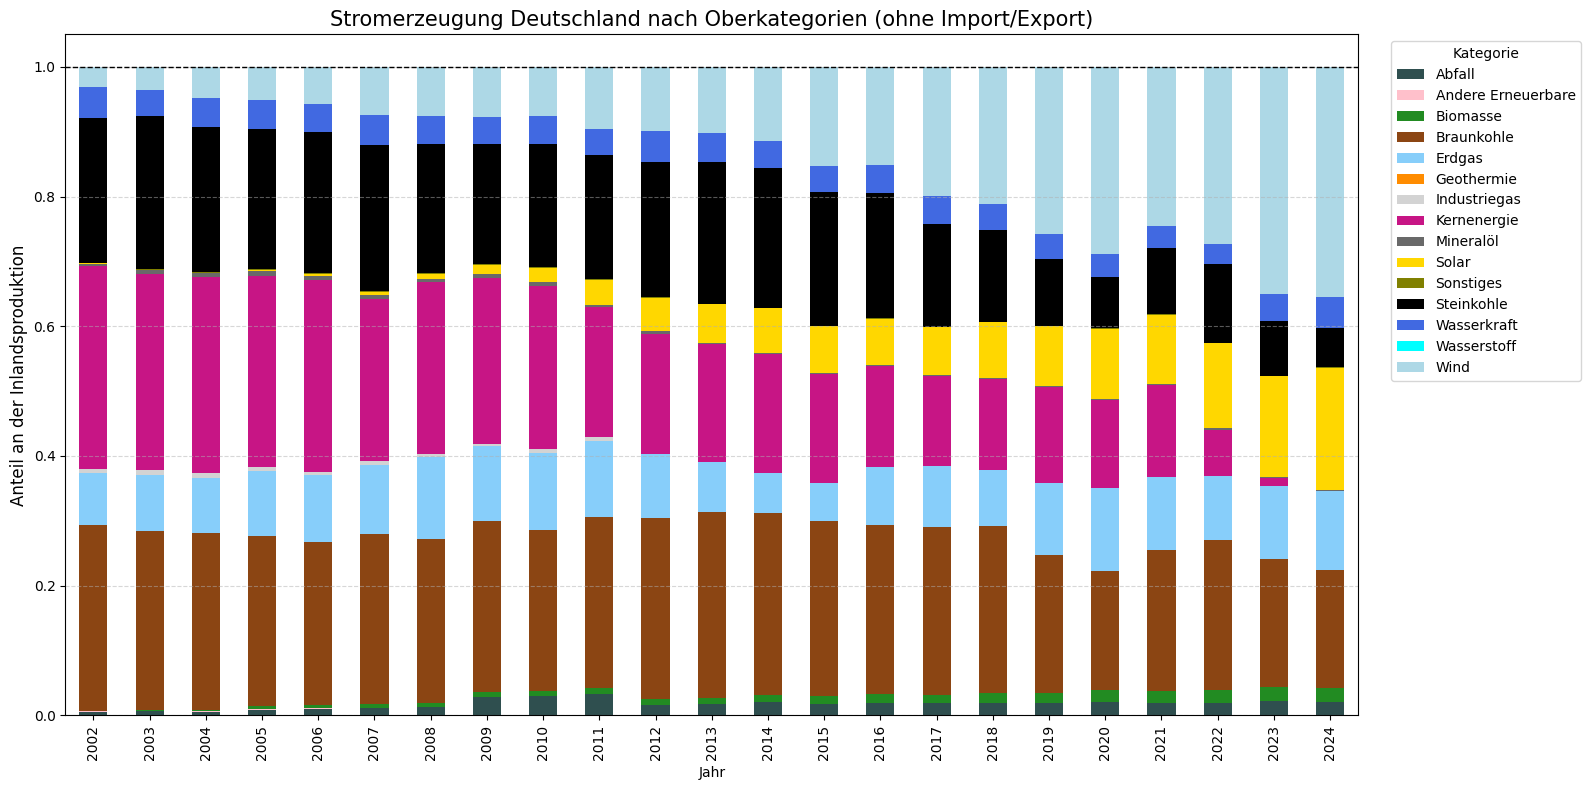

In [ ]:
# Inlandsproduktion
produktion_only = produktion_kat.copy()
produktion_only = produktion_only[~produktion_only["Kategorie"].isin(["Importanteil", "Exportüberschuss"])]

# Normierung
produktion_only_pivot = produktion_only.pivot_table(
    index="Jahr",
    columns="Kategorie",
    values="Anteil",
    aggfunc="sum"
).fillna(0)
produktion_only_pivot = produktion_only_pivot.div(produktion_only_pivot.sum(axis=1), axis=0)

categories_no_import_export = list(produktion_only_pivot.columns)
colors_no_import_export = [color_map[cat] for cat in categories_no_import_export]

produktion_only_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 8),
    color=colors_no_import_export
)

plt.axhline(1, color='black', linestyle='--', linewidth=1)  # 100%
plt.title("Stromerzeugung Deutschland nach Oberkategorien (ohne Import/Export)", fontsize=15)
plt.ylabel("Anteil an der Inlandsproduktion", fontsize=12)
plt.xlabel("Jahr")
plt.legend(title="Kategorie", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


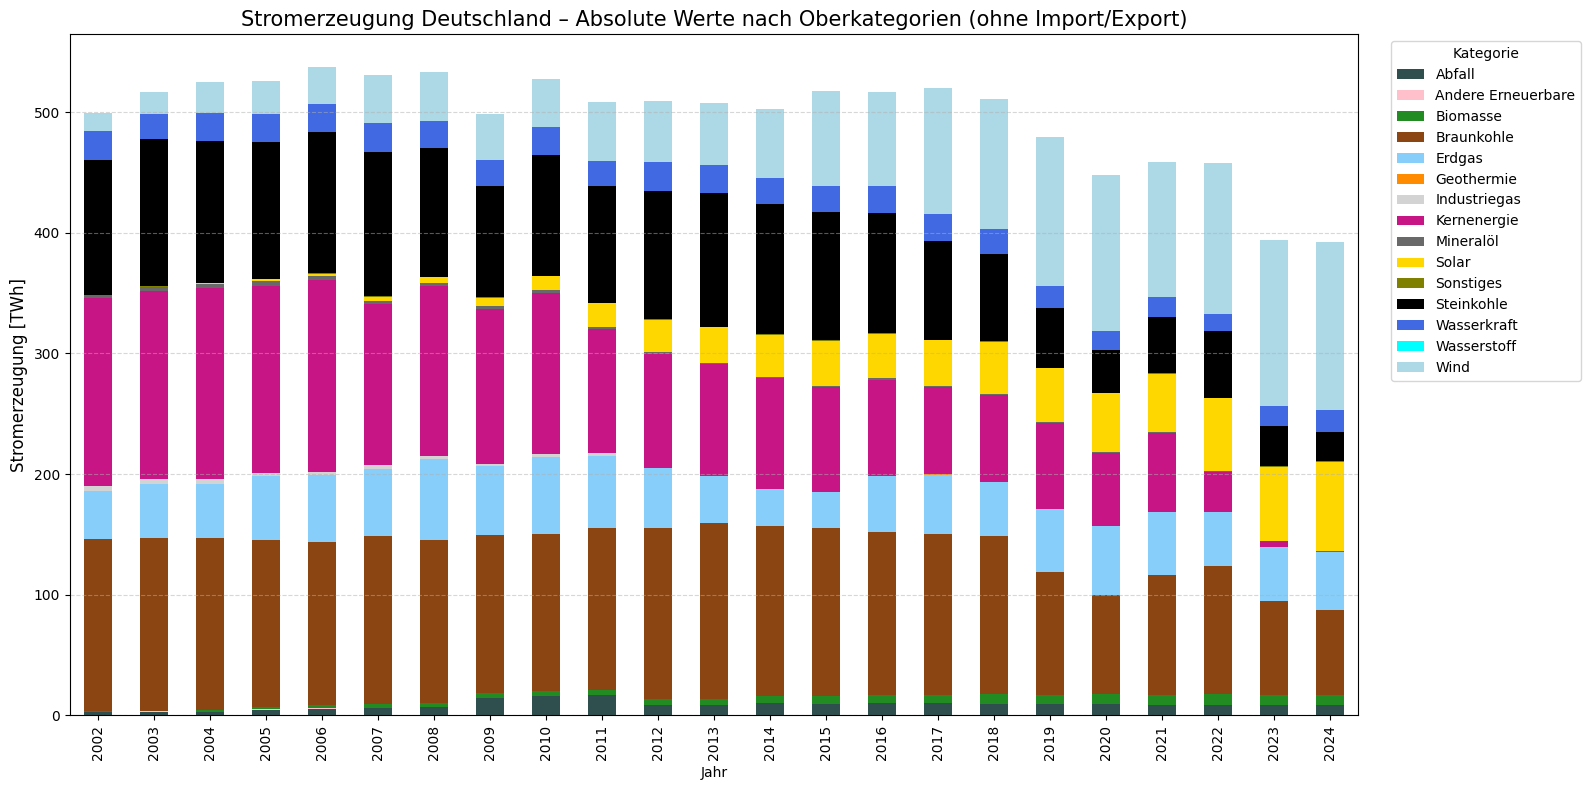

In [ ]:
# === Nur Inlandsproduktion, ohne Import/Export
produktion_absolute_only = produktion.copy()
produktion_absolute_only = produktion_absolute_only[
    ~produktion_absolute_only["Kategorie"].isin(["Importanteil", "Exportüberschuss"])
]

# === Pivot auf absolute Werte
produktion_absolute_pivot = produktion_absolute_only.pivot_table(
    index="Jahr",
    columns="Kategorie",
    values="Elektrizitätserzeugung (netto)",
    aggfunc="sum"
).fillna(0)

# === Einheit umrechnen: MWh -> TWh
produktion_absolute_pivot = produktion_absolute_pivot / 1_000_000  # 1 TWh = 1 Mio MWh

# === Farben in korrekter Reihenfolge
categories_absolute = list(produktion_absolute_pivot.columns)
colors_absolute = [color_map.get(cat, "hotpink") for cat in categories_absolute]

# === Plot
ax = produktion_absolute_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 8),
    color=colors_absolute
)

ax.set_title("Stromerzeugung Deutschland – Absolute Werte nach Oberkategorien (ohne Import/Export)", fontsize=15)
ax.set_ylabel("Stromerzeugung [TWh]", fontsize=12)
ax.set_xlabel("Jahr")
ax.legend(title="Kategorie", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Jahr,Kategorie,Typ,Unit,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Abfall,"Abfall (Hausmüll, Industrie)",MWh,2926818.0,3182945.0,3094261.0,4524205.0,5523466.0,6398662.0,7049002.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abfall,"Abfall (Hausmüll, Siedlungsabfälle)",MWh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8678621.0,9003436.0,9103612.0,9368342.0,8807724.0,8806724.0,8559383.0,8248923.0,8426706.0,8103057.0
2,Abfall,Abfall (Industrie),MWh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,822492.0,942120.0,864336.0,532107.0,546308.0,394625.0,375927.0,368800.0,337381.0,302544.0
3,Andere Erneuerbare,Sonstige erneuerbare Energien,MWh,243469.0,146692.0,193418.0,501970.0,364129.0,20829.0,434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Biomasse,Biogas,MWh,30547.0,16499.0,18696.0,17191.0,10830.0,41389.0,56019.0,...,1656879.0,1730984.0,1757636.0,1776954.0,1909288.0,2177331.0,2305019.0,2662856.0,2628872.0,2564677.0
5,Biomasse,Biomethan (Bioerdgas),MWh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,766717.0,786940.0,904378.0,1036391.0,1007771.0,936420.0,868105.0
6,Biomasse,Deponiegas,MWh,110551.0,118181.0,180303.0,201636.0,183550.0,169709.0,153170.0,...,83700.0,72410.0,67784.0,53825.0,54243.0,70880.0,62707.0,56080.0,53592.0,58672.0
7,Biomasse,Feste biogene Stoffe,MWh,201651.0,255228.0,675774.0,1542493.0,1726401.0,2100075.0,2635180.0,...,4376181.0,4682300.0,4703454.0,4621836.0,4365482.0,4441567.0,4215786.0,4555379.0,4314766.0,4074438.0
8,Biomasse,Flüssige biogene Stoffe,MWh,0.0,0.0,0.0,17864.0,36419.0,57463.0,52248.0,...,890.0,0.0,1013.0,0.0,0.0,3449.0,0.0,0.0,0.0,0.0
9,Biomasse,Grubengas,MWh,215765.0,286779.0,313046.0,377588.0,488123.0,501313.0,387442.0,...,0.0,134240.0,78413.0,138398.0,82699.0,716510.0,606925.0,577320.0,501442.0,486810.0


In [46]:
#['Abfall', 'Andere Erneuerbare', 'Biomasse', 'Braunkohle', 'Erdgas', 'Export', 'Geothermie', 'Import', 'Import/Export', 'Industriegas', 'Kernenergie', 'Mineralöl', 
# 'SUMME', 'Solar', 'Sonstiges', 'Steinkohle', 'Wasserkraft', 'Wasserstoff', 'Wind']
include_kategorien = ['Abfall', 'Biomasse', 'Braunkohle', 'Erdgas', 
                      'Geothermie', 'Industriegas', 'Kernenergie', 
                      'Mineralöl', 'Solar', 'Sonstiges', 'Steinkohle', 
                      'Wasserkraft', 'Wind', 'Wasserstoff'] # , 'Import', 'Export'

strommix_filtered = strommix_gesamt[strommix_gesamt["Kategorie"].isin(include_kategorien)]

# Sum by Kategorie and Jahr
strommix_for_prophet = (
    strommix_filtered
    .groupby(["Kategorie", "Jahr"], as_index=False)
    .agg({"Elektrizitätserzeugung (netto)": "sum"})
)

# Prophet labels
strommix_for_prophet = strommix_for_prophet.rename(columns={
    "Jahr": "ds",
    "Elektrizitätserzeugung (netto)": "y"
})

# year to datetime
strommix_for_prophet["ds"] = pd.to_datetime(strommix_for_prophet["ds"], format="%Y")

# Inbetween to print the included categories in the data
included_categories_test = sorted(strommix_for_prophet["Kategorie"].unique())
print(f"Prophet Kategorien: {', '.join(included_categories_test)}")
ignorierte_kategorien = [cat for cat in TOP_LEVEL_CATEGORIES if cat not in included_categories_test]

print(f"Ignorierte Kategorien: {', '.join(ignorierte_kategorien)}")
print(f"Es sind {len(included_categories_test)} from {len(include_kategorien)} that are allowed from {len(TOP_LEVEL_CATEGORIES)} total.")


strommix_for_prophet


Prophet Kategorien: Abfall, Biomasse, Braunkohle, Erdgas, Geothermie, Industriegas, Kernenergie, Mineralöl, Solar, Sonstiges, Steinkohle, Wasserkraft, Wasserstoff, Wind
Ignorierte Kategorien: Andere Erneuerbare, Export, Import, Import/Export, SUMME
Es sind 14 from 14 that are allowed from 19 total.


,Kategorie,ds,y
0,Abfall,2002-01-01,2926818.0
1,Abfall,2003-01-01,3182945.0
2,Abfall,2004-01-01,3094261.0
3,Abfall,2005-01-01,4524205.0
4,Abfall,2006-01-01,5523466.0
...,...,...,...
317,Wind,2020-01-01,129600000.0
318,Wind,2021-01-01,112500000.0
319,Wind,2022-01-01,124800000.0
320,Wind,2023-01-01,137800000.0


In [ ]:
from prophet import Prophet

forecast_years = [2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060]
future_dates = pd.DataFrame({'ds': pd.to_datetime([f'{year}-01-01' for year in forecast_years])})

all_forecasts = []

for category in strommix_for_prophet['Kategorie'].unique():
    # Filter data for the current category
    df_cat = strommix_for_prophet[strommix_for_prophet['Kategorie'] == category][['ds', 'y']].copy()
    df_cat['ds'] = pd.to_datetime(df_cat['ds'])

    # Skip if all values are zero or missing
    if df_cat['y'].sum() == 0 or df_cat['y'].isna().all():
        continue

    model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_cat)

    # Predict for future years
    forecast = model.predict(future_dates)
    forecast['Kategorie'] = category
    
        
    # Clamp forecasts to zero to avoid negative energy values
    forecast['yhat'] = forecast['yhat'].clip(lower=0)  
  

    forecast_result = forecast[['ds', 'yhat', 'Kategorie']]

    all_forecasts.append(forecast_result)

# Combine all category forecasts
final_forecast_df = pd.concat(all_forecasts, ignore_index=True)


18:33:53 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:53 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:53 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:55 - cmdstanpy - INFO - Chain [1]

In [62]:
# Modify Predictions

# Clamp Kernenergie to 0 because it has been banned
final_forecast_df.loc[final_forecast_df["Kategorie"] == "Kernenergie", "yhat"] = 0


In [64]:
import matplotlib.pyplot as plt

# Merge original and forecasted data for unified plotting
original = strommix_for_prophet.copy()
original['ds'] = pd.to_datetime(original['ds'])
original['Type'] = 'Historisch'
original = original.rename(columns={'y': 'value'})

forecast = final_forecast_df.copy()
forecast['Type'] = 'Prognose'
forecast = forecast.rename(columns={'yhat': 'value'})

# Combine both
combined = pd.concat([
    original[['Kategorie', 'ds', 'value', 'Type']],
    forecast[['Kategorie', 'ds', 'value', 'Type']]
])

# include_saldo_forecast = False  # Set to False to exclude Import/Export forecast

# if include_saldo_forecast:
#     # Prepare historical saldo from existing data
#     historical_saldo = strommix_for_prophet[strommix_for_prophet["Kategorie"] == "Austauschsaldo"].copy()
#     historical_saldo["Kategorie"] = "Import / Export"
#     historical_saldo["Type"] = "Historisch"
#     historical_saldo = historical_saldo.rename(columns={"y": "value"})
#     historical_saldo = historical_saldo[["Kategorie", "ds", "value", "Type"]]

#     # Prepare forecast saldo
#     saldo_forecast = saldo_total.copy()
#     saldo_forecast["Kategorie"] = "Import / Export"
#     saldo_forecast["Type"] = "Prognose"
#     saldo_forecast = saldo_forecast.rename(columns={"Elektrizitätserzeugung (netto)": "value"})
#     saldo_forecast = saldo_forecast[["Kategorie", "ds", "value", "Type"]]

#     # Combine both historical + forecast saldo
#     saldo_combined = pd.concat([historical_saldo, saldo_forecast], ignore_index=True)

#     # Add to combined
#     combined = pd.concat([combined, saldo_combined], ignore_index=True)


combined[combined['ds'] == '2025-01-01']

,Kategorie,ds,value,Type
0,Abfall,2025-01-01,1.116449e+07,Prognose
8,Biomasse,2025-01-01,9.835276e+06,Prognose
16,Braunkohle,2025-01-01,9.359909e+07,Prognose
24,Erdgas,2025-01-01,4.674384e+07,Prognose
32,Geothermie,2025-01-01,3.674068e+04,Prognose
40,Industriegas,2025-01-01,0.000000e+00,Prognose
48,Kernenergie,2025-01-01,0.000000e+00,Prognose
56,Mineralöl,2025-01-01,1.226912e+05,Prognose
64,Solar,2025-01-01,6.715822e+07,Prognose
72,Sonstiges,2025-01-01,5.227402e+05,Prognose


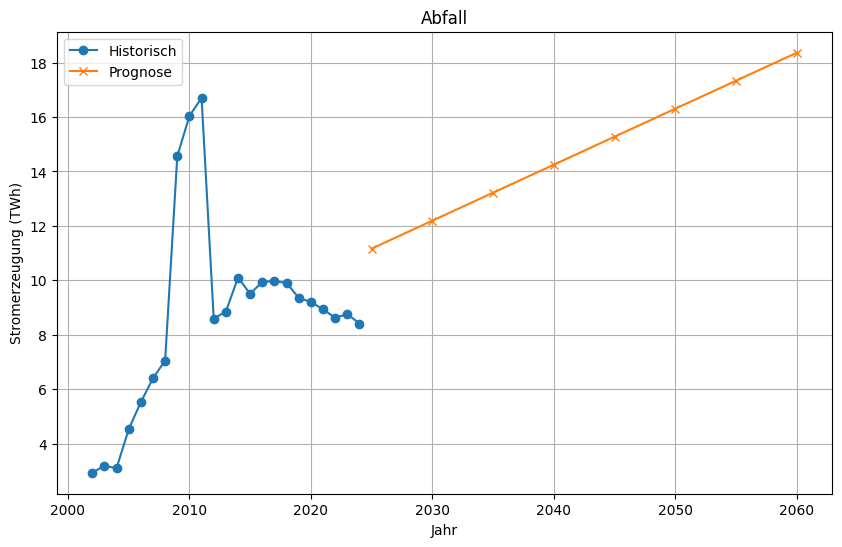

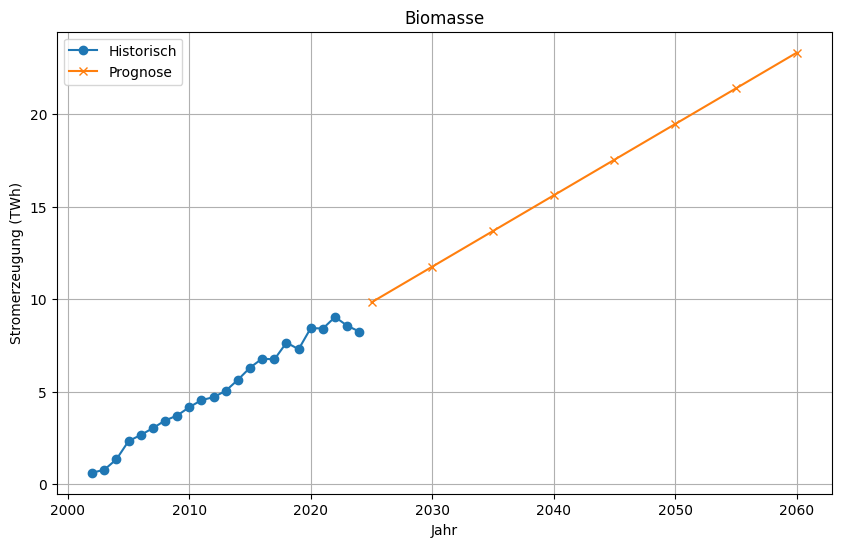

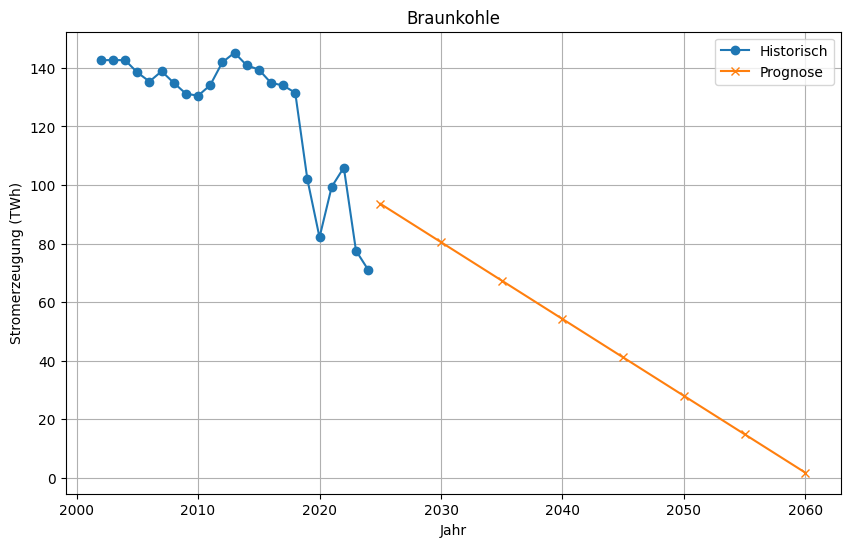

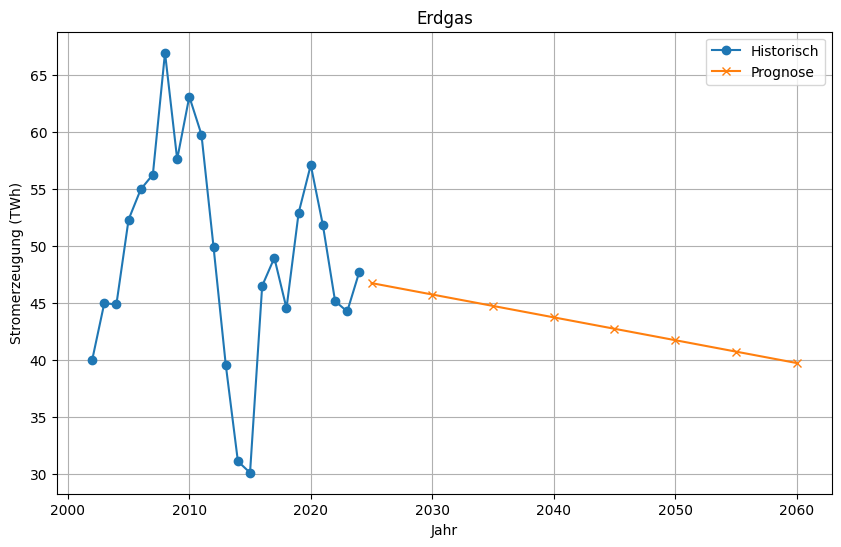

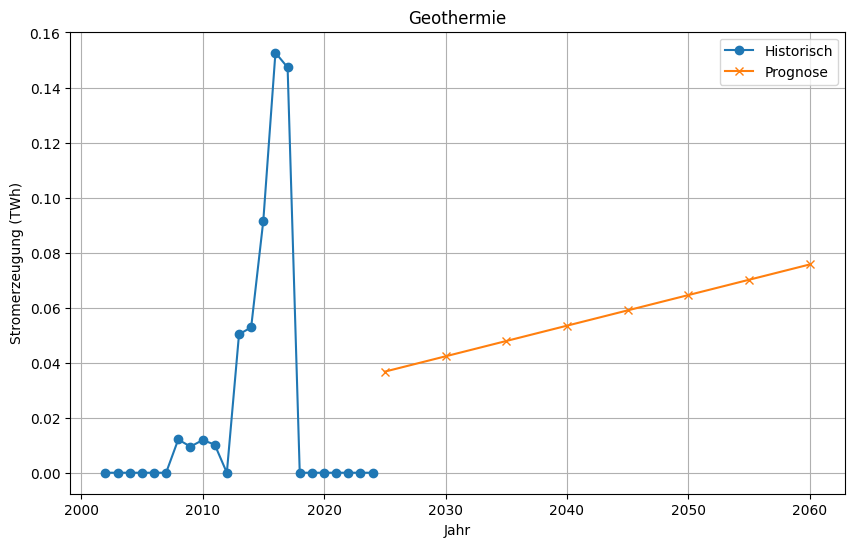

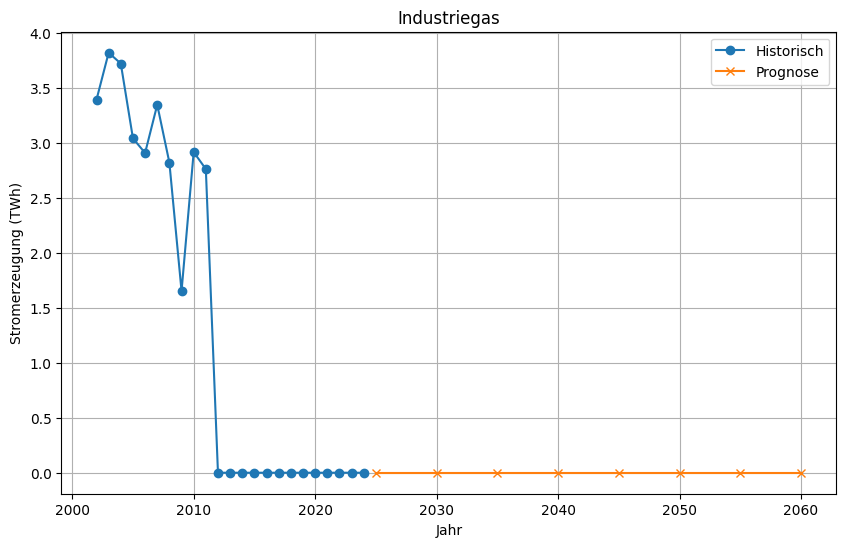

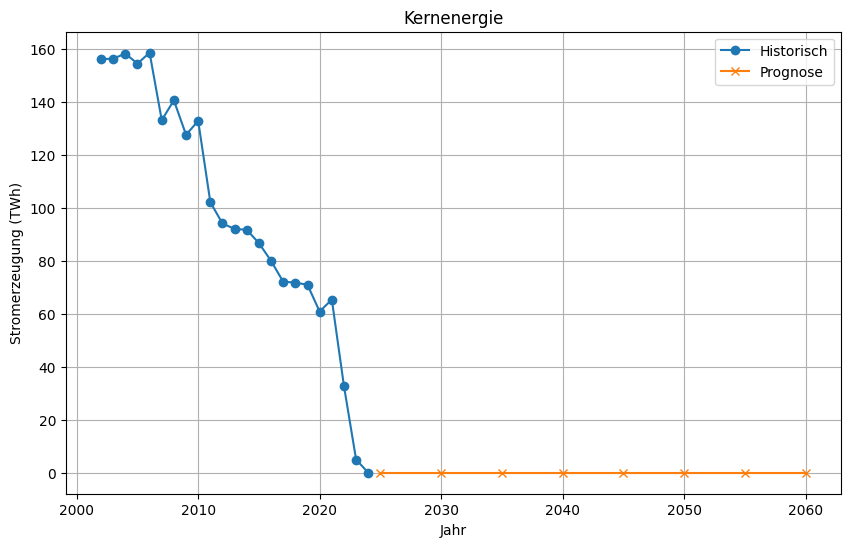

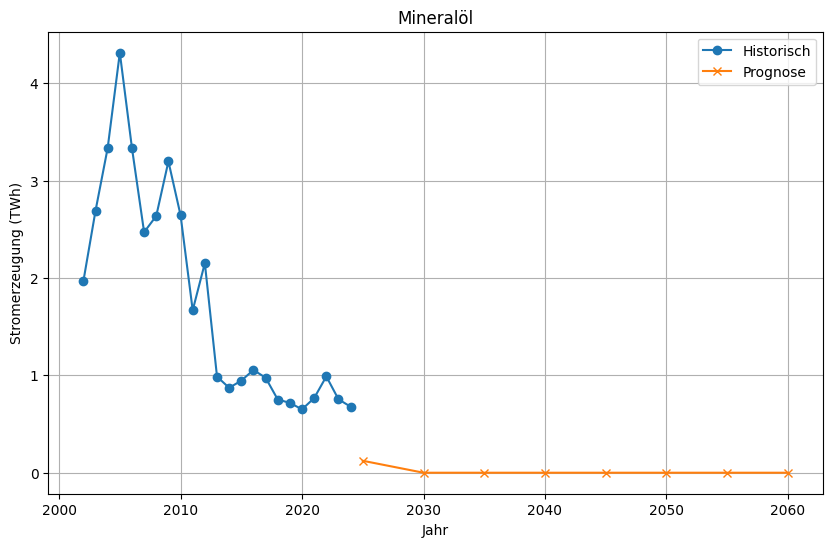

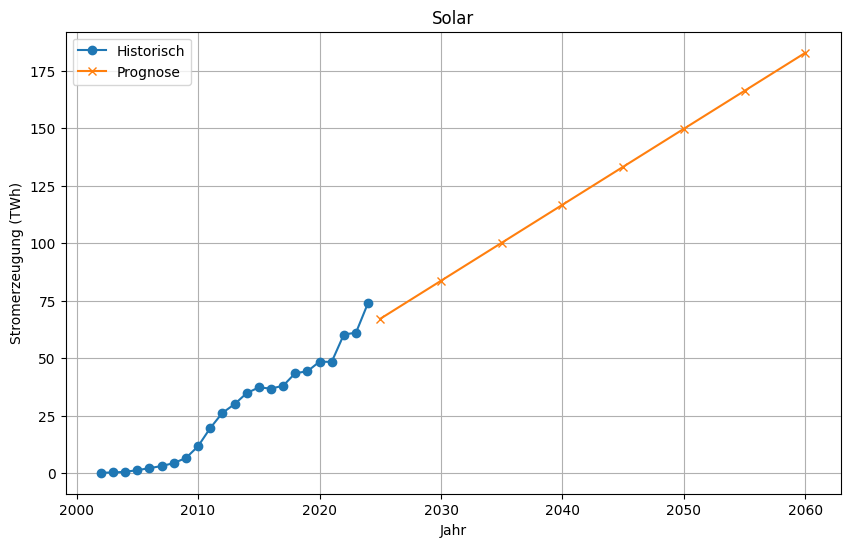

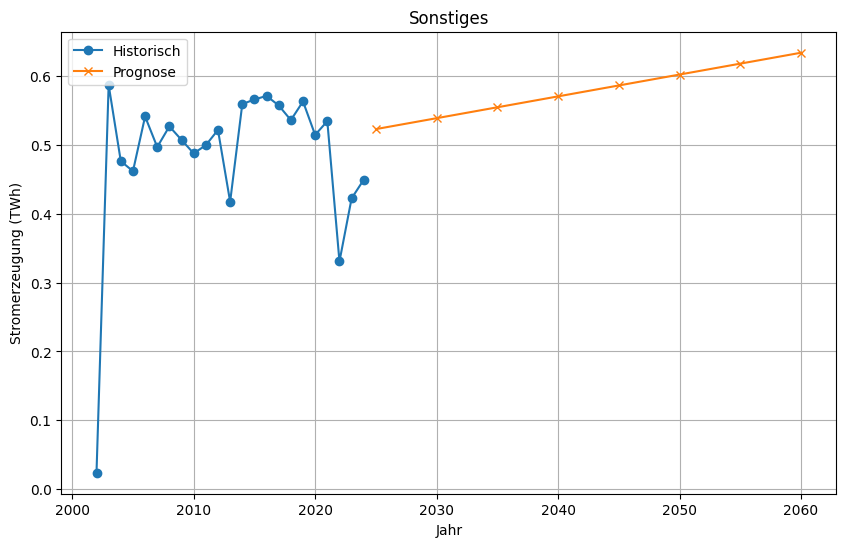

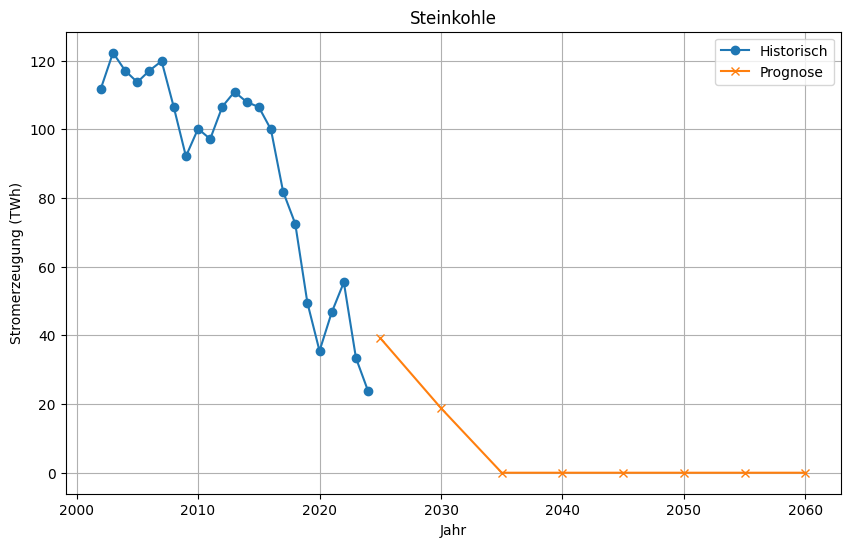

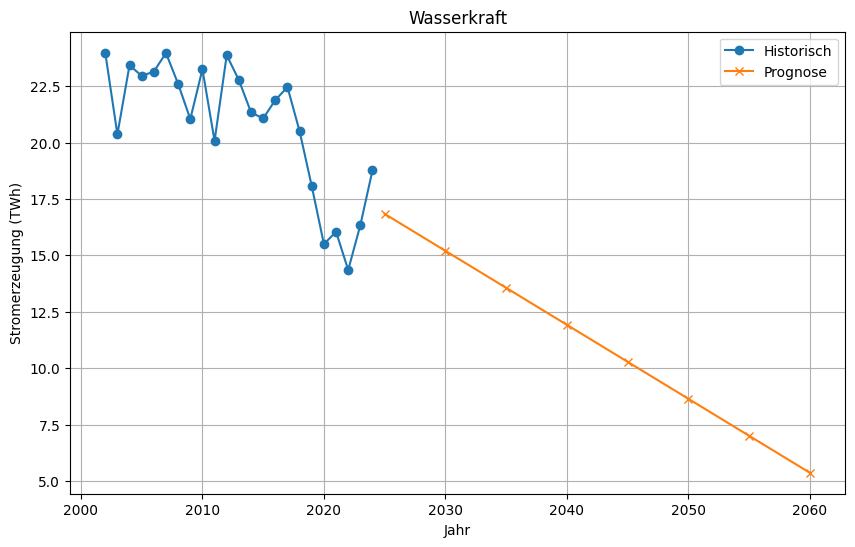

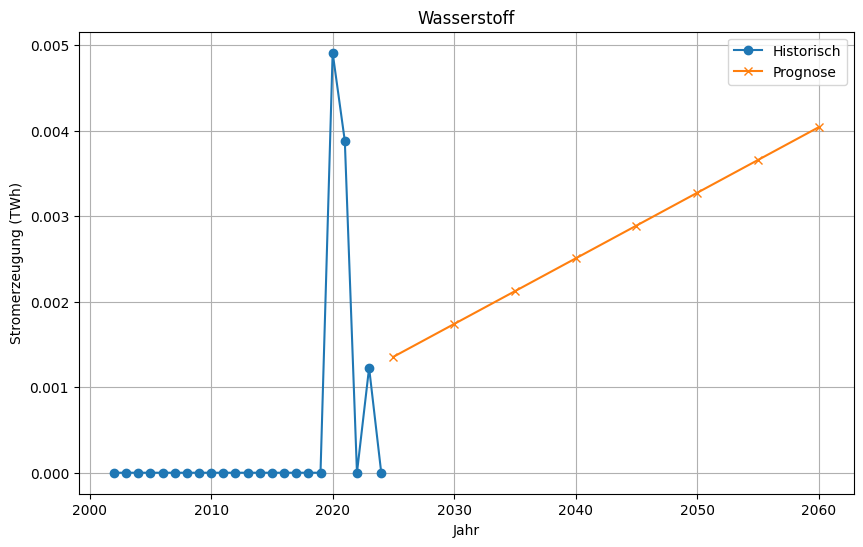

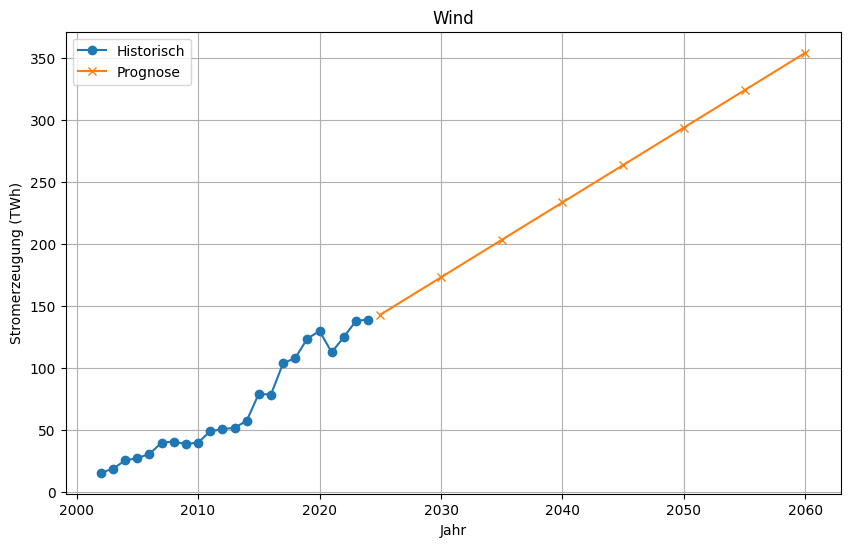

In [ ]:

# # Plot each Kategorie
# categories = combined['Kategorie'].unique()
# n_cols = 2
# n_rows = (len(categories) + 1) // n_cols
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), constrained_layout=True)

# for idx, category in enumerate(categories):
#     ax = axes.flatten()[idx]
#     cat_data = combined[combined['Kategorie'] == category]
#     for label, grp in cat_data.groupby('Type'):
#         ax.plot(grp['ds'], grp['value'], marker='o' if label == 'Historisch' else 'x', label=label)
#     ax.set_title(category)
#     ax.set_xlabel('Jahr')
#     ax.set_ylabel('Stromerzeugung (MWh)')
#     ax.legend()
#     ax.grid(True)

# # If there's an odd number of plots, hide the last empty subplot
# if len(categories) % n_cols != 0:
#     axes.flatten()[-1].axis('off')

# plt.suptitle('Strommix: Historische Daten und Prognosen pro Kategorie', fontsize=16)
# plt.show()
import os
import matplotlib.pyplot as plt

# Create output directory if not exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Convert to TWh
combined_twh = combined.copy()
combined_twh["value"] = combined_twh["value"] / 1_000_000

# Get global y-axis limits for consistent scaling
y_min = combined_twh['value'].min()
y_max = combined_twh['value'].max()

# Plot and save each category
for category in combined_twh['Kategorie'].unique():
    cat_data = combined_twh[combined_twh['Kategorie'] == category]
    fig, ax = plt.subplots(figsize=(10, 6))

    for label, grp in cat_data.groupby('Type'):
        marker = 'o' if label == 'Historisch' else 'x'
        ax.plot(grp['ds'], grp['value'], marker=marker, label=label)

    ax.set_title(category)
    ax.set_xlabel('Jahr')
    ax.set_ylabel('Stromerzeugung (TWh)')
    # ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True)

    # Save the plot
    cat_name = category.lower().replace(' ', '_').replace('/', "_")
    filename = f"prediction_{cat_name}.png"
    fig.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')

    # Show in notebook
    plt.show()


In [ ]:
### FIXME move exports down



# === CONFIG ===
kategorie_to_variable = {
    "Abfall": "Electricity generation|Wastes",  # Aggregated
    "Biomasse": "Electricity generation|Biomass",  # Top-level
    "Braunkohle": "Electricity generation|Coal|Fossil|Lignite",  
    "Erdgas": "Electricity generation|Gas|Fossil gases",  
    "Geothermie": "Electricity generation|Geothermal",  
    "Industriegas": "Electricity generation|Gas|Fossil gases|Industrial CHPs gas",  
    "Kernenergie": "Electricity generation|Nuclear Fuel|Nuclear power plants",
    "Mineralöl": "Electricity generation|Oil|Fossil liquids",  
    "Solar": "Electricity generation|Solar",  
    "Sonstiges": "Electricity generation|Other",  
    "Steinkohle": "Electricity generation|Coal|Fossil|Hard coal",  
    "Wasserkraft": "Electricity generation|Hydro",  
    "Wind": "Electricity generation|Wind" ,
    
    "Wasserstoff": "Electricity generation|Hydrogen", # todo to be added

}

target_years = [2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060]

# === Step 1: Filter combined dataset ===
df_filtered = combined[combined['ds'].dt.year.isin(target_years)].copy()

# Convert MWh to PJ
df_filtered['PJ'] = df_filtered['value'] * 3.6 / 1_000_000
df_filtered['year'] = df_filtered['ds'].dt.year

# Map Kategorie -> IAM variable name
df_filtered['variable'] = df_filtered['Kategorie'].map(kategorie_to_variable)

# Drop rows with unmapped variables (optional safety)
df_filtered = df_filtered.dropna(subset=['variable'])

# === Step 2: Pivot to wide format ===
pivot = df_filtered.pivot_table(
    index="variable",
    columns="year",
    values="PJ",
    aggfunc="sum"
).reset_index()

# === Step 3: Add SWEET/Premise metadata columns ===
pivot["scenario"] = "Base"
pivot["region"] = "DE"
pivot["unit"] = "PJ/yr."

# Reorder columns to match SWEET structure
export_columns = ["scenario", "region", "variable", "unit"] + target_years
final_export = pivot[export_columns]

# === Step 4: Export to CSV ===
final_export.to_csv("electricity_generation_sps1_DE.csv", index=False)

# Optional: Display preview
display(final_export)


year,scenario,region,variable,unit,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060
0,Base,DE,Electricity generation|Biomass,PJ/yr.,8.399891,14.995811,22.692510,30.394933,35.406992,42.348039,49.289087,56.230134,63.174983,70.116031,77.057078,83.998125
1,Base,DE,Electricity generation|Coal|Fossil|Hard coal,PJ/yr.,409.381387,360.561960,383.358622,127.665234,141.147137,67.686188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Base,DE,Electricity generation|Coal|Fossil|Lignite,PJ/yr.,498.355394,469.723579,501.931757,295.659371,336.956735,289.721039,242.485343,195.249648,147.988084,100.752388,53.516693,6.280997
3,Base,DE,Electricity generation|Gas|Fossil gases,PJ/yr.,188.322768,227.128702,108.443635,205.546316,168.277809,164.675390,161.072971,157.470553,153.866161,150.263743,146.661324,143.058906
4,Base,DE,Electricity generation|Gas|Fossil gases|Indust...,PJ/yr.,10.943503,10.494652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Base,DE,Electricity generation|Geothermal,PJ/yr.,0.000000,0.042689,0.329515,0.000000,0.132266,0.152307,0.172348,0.192389,0.212441,0.232482,0.252523,0.272564
6,Base,DE,Electricity generation|Hydro,PJ/yr.,82.620094,83.698736,75.845772,55.805998,60.621451,54.722252,48.823053,42.923854,37.021425,31.122226,25.223027,19.323828
7,Base,DE,Electricity generation|Hydrogen,PJ/yr.,0.000000,0.000000,0.000000,0.017683,0.004882,0.006262,0.007642,0.009022,0.010403,0.011783,0.013164,0.014544
8,Base,DE,Electricity generation|Nuclear Fuel|Nuclear po...,PJ/yr.,556.604262,478.694340,312.354025,219.291570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Base,DE,Electricity generation|Oil|Fossil liquids,PJ/yr.,15.529709,9.521636,3.404804,2.342794,0.441688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


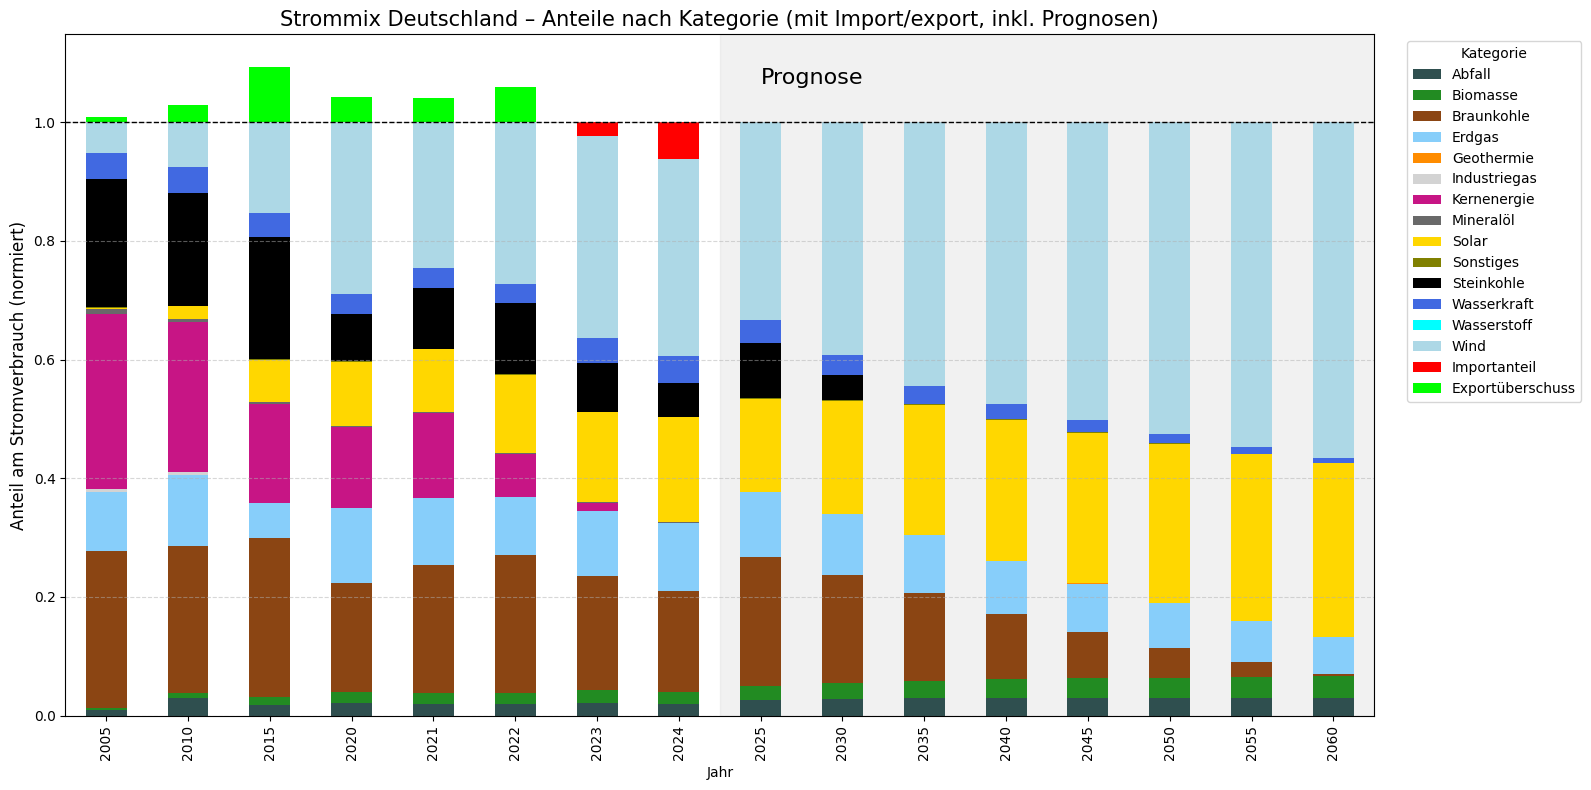

In [105]:
target_years = [2005, 2010, 2015, 2020, 2021, 2022, 2023, 2024, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060]

# Helper func
def shade_forecast_area(ax, forecast_start_year=2025, color='lightgray', alpha=0.3, label="Prognose"):
    """
    Shade the forecast area starting from forecast_start_year on a bar plot.
    
    Parameters:
    - ax: matplotlib Axes object
    - forecast_start_year: int, first year of forecast
    - color: background color
    - alpha: transparency
    - label: optional text label to display
    """

    bar_centers = []
    seen_x_positions = set()

    for patch in ax.patches:
        try:
            x = patch.get_x()
            width = patch.get_width()
            x_center = x + width / 2

            if x_center not in seen_x_positions:
                bar_centers.append(x_center)
                seen_x_positions.add(x_center)
        except AttributeError:
            # ignore polygons without get_x()
            continue

    # Map bar_centers to years:
    try:
        bar_years = [int(label.get_text()) for label in ax.get_xticklabels()]
    except:
        bar_years = list(range(len(bar_centers)))

    year_to_center = dict(zip(bar_years, bar_centers))

    if forecast_start_year in year_to_center:
        start_forecast = year_to_center[forecast_start_year] - 0.5
        ax.axvspan(
            start_forecast, ax.get_xlim()[1],
            color=color, alpha=alpha, zorder=0
        )

        if label:
            ax.text(
                start_forecast + 0.5,
                ax.get_ylim()[1] * 0.95,
                label,
                verticalalignment='top',
                horizontalalignment='left',
                fontsize=16,
                color='black'
            )



## ---


# Prepare production data (historical + forecast)
prod_combined = combined[combined['Kategorie'].isin(include_kategorien)].copy()
prod_combined["Jahr"] = prod_combined["ds"].dt.year
prod_combined = prod_combined[["Jahr", "Kategorie", "value", "Type"]]

# Historical Import/Export (2002–2024)
saldo_df = strommix_gesamt[strommix_gesamt["Typ"] == "Austauschsaldo"].copy()
saldo_df = saldo_df[(saldo_df["Jahr"] >= 2002) & (saldo_df["Jahr"] <= 2024)]
saldo_df = saldo_df[["Jahr", "Elektrizitätserzeugung (netto)"]].rename(columns={"Elektrizitätserzeugung (netto)": "Austauschsaldo"})

# Inlandsproduktion for historical years
historical_prod = prod_combined[prod_combined["Type"] == "Historisch"]
inlandsproduktion = historical_prod.groupby("Jahr")["value"].sum().reset_index().rename(columns={"value": "Inlandsproduktion"})

# Basis historical = production + saldo
basis = inlandsproduktion.merge(saldo_df, on="Jahr", how="left").fillna(0)

# Anteil berechnen für historische Daten
historical_merged = historical_prod.merge(basis, on="Jahr", how="left")
historical_merged["Anteil"] = historical_merged["value"] / (
    historical_merged["Inlandsproduktion"] + historical_merged["Austauschsaldo"].clip(lower=0)
)

# Forecast Anteile berechnen (ohne Import/Export)
forecast = prod_combined[prod_combined["Type"] == "Prognose"].copy()
forecast_total = forecast.groupby("Jahr")["value"].sum().reset_index().rename(columns={"value": "Inlandsproduktion"})
forecast = forecast.merge(forecast_total, on="Jahr")
forecast["Anteil"] = forecast["value"] / forecast["Inlandsproduktion"]

# Import/Export (nur historische Jahre)
import_df = basis[basis["Austauschsaldo"] > 0].copy()
import_df["Anteil"] = import_df["Austauschsaldo"] / (import_df["Inlandsproduktion"] + import_df["Austauschsaldo"])
import_df["Kategorie"] = "Importanteil"

export_df = basis[basis["Austauschsaldo"] < 0].copy()
export_df["Anteil"] = -export_df["Austauschsaldo"] / export_df["Inlandsproduktion"]
export_df["Kategorie"] = "Exportüberschuss"

# Combine all + filter to target_years
final_rel = pd.concat([
    historical_merged[["Jahr", "Kategorie", "Anteil"]],
    forecast[["Jahr", "Kategorie", "Anteil"]],
    import_df[["Jahr", "Kategorie", "Anteil"]],
    export_df[["Jahr", "Kategorie", "Anteil"]]
])
final_rel = final_rel[final_rel["Jahr"].isin(target_years)]

# Pivot für Stacked Bar Plot
pivot_plot = final_rel.pivot_table(
    index="Jahr",
    columns="Kategorie",
    values="Anteil",
    aggfunc="sum"
).fillna(0)

# Export/Import at end
cols = list(pivot_plot.columns)
for special in ["Importanteil", "Exportüberschuss"]:
    if special in cols:
        cols = [c for c in cols if c != special] + [special]
pivot_plot = pivot_plot[cols]

# Farben und Plot
tab20_colors = plt.get_cmap("tab20").colors
safe_colors = [c for i, c in enumerate(tab20_colors) if i not in [4,5,6]]
categories = list(pivot_plot.columns)

colors = [color_map.get(cat, "hotpink") for cat in categories]


# Plot
ax = pivot_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 8),
    color=colors
)

plt.axhline(1, color='black', linestyle='--', linewidth=1)
plt.title("Strommix Deutschland – Anteile nach Kategorie (mit Import/export, inkl. Prognosen)", fontsize=15)
plt.ylabel("Anteil am Stromverbrauch (normiert)", fontsize=12)
plt.xlabel("Jahr")
plt.legend(title="Kategorie", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.5)

shade_forecast_area(ax)  # <<< ADD THIS LINE!


plt.tight_layout()
plt.show()


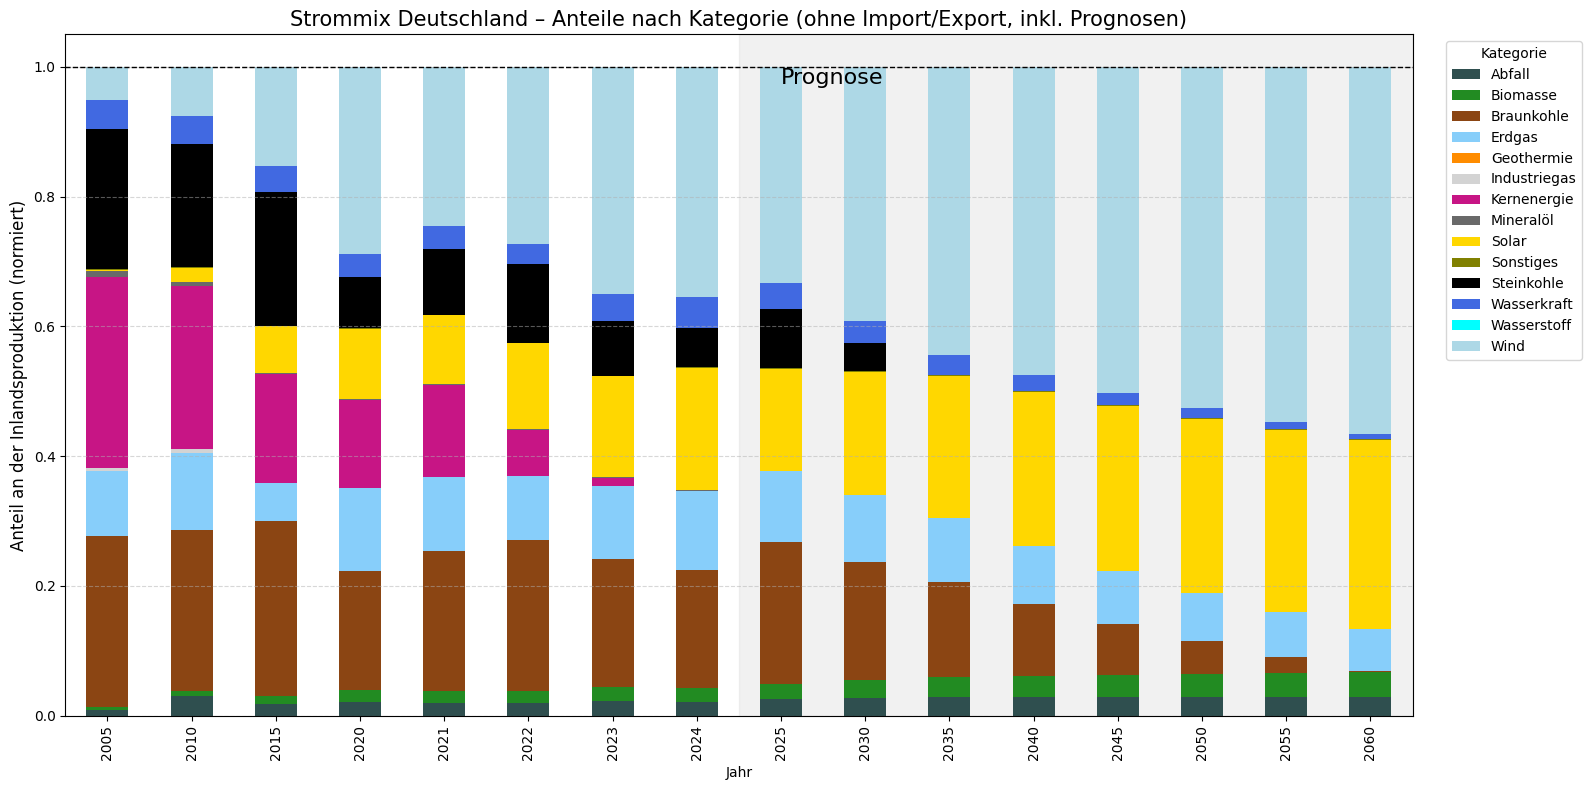

In [107]:
# === New pivot without Importanteil / Exportüberschuss
pivot_plot_no_import = final_rel[
    ~final_rel["Kategorie"].isin(["Importanteil", "Exportüberschuss"])
].pivot_table(
    index="Jahr",
    columns="Kategorie",
    values="Anteil",
    aggfunc="sum"
).fillna(0)

# Normalize again (sum = 1.0 each year)
pivot_plot_no_import = pivot_plot_no_import.div(pivot_plot_no_import.sum(axis=1), axis=0)

# New category list
categories_no_import = list(pivot_plot_no_import.columns)

# Reuse color_map safely
colors_no_import = [color_map.get(cat, "hotpink") for cat in categories_no_import]

# === Plot (no Import/Export)
ax = pivot_plot_no_import.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 8),
    color=colors_no_import
)

plt.axhline(1, color='black', linestyle='--', linewidth=1)
plt.title("Strommix Deutschland – Anteile nach Kategorie (ohne Import/Export, inkl. Prognosen)", fontsize=15)
plt.ylabel("Anteil an der Inlandsproduktion (normiert)", fontsize=12)
plt.xlabel("Jahr")
plt.legend(title="Kategorie", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.5)

shade_forecast_area(ax) 


plt.tight_layout()
plt.show()


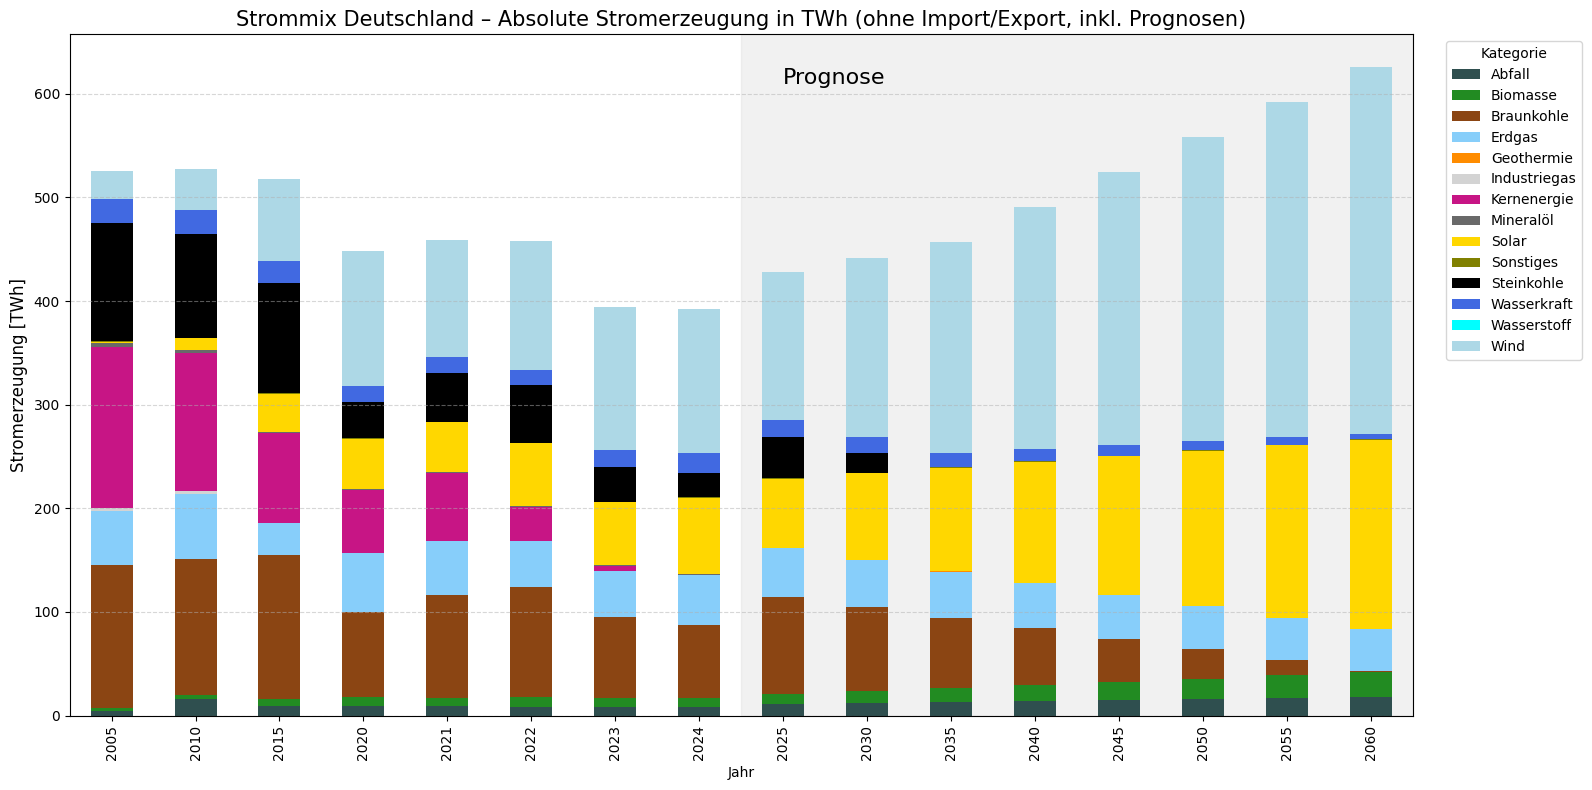

In [ ]:
# === Only use categories you want
prod_absolute = combined[combined['Kategorie'].isin(include_kategorien)].copy()

# === Convert MWh to TWh
prod_absolute["value"] = prod_absolute["value"] / 1_000_000  # MWh -> TWh

# === Prepare absolute pivot table (no Import/Export)
prod_absolute["Jahr"] = prod_absolute["ds"].dt.year

pivot_absolute = prod_absolute[prod_absolute["Jahr"].isin(target_years)].pivot_table(
    index="Jahr",
    columns="Kategorie",
    values="value",
    aggfunc="sum"
).fillna(0)

# === Sort years manually to match target_years
pivot_absolute = pivot_absolute.reindex(target_years)

# === Define color order
categories_absolute = list(pivot_absolute.columns)
colors_absolute = [color_map.get(cat, "hotpink") for cat in categories_absolute]

# === Create plot and capture ax
ax = pivot_absolute.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 8),
    color=colors_absolute
)

# === Standard labels
ax.set_title("Strommix Deutschland – Absolute Stromerzeugung in TWh (ohne Import/Export, inkl. Prognosen)", fontsize=15)
ax.set_ylabel("Stromerzeugung [TWh]", fontsize=12)
ax.set_xlabel("Jahr")
ax.legend(title="Kategorie", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.grid(axis='y', linestyle='--', alpha=0.5)

shade_forecast_area(ax)

plt.tight_layout()
plt.show()


In [71]:

# https://premise.readthedocs.io/en/latest/mapping.html
# MAPPINGS: https://github.com/polca/premise/blob/master/premise/iam_variables_mapping/electricity_variables.yaml

# Export

In [113]:
# Strommix ursprungliche Daten Export, ohne Prognose


# Pivot: Jahre = Zeilen, Kategorien = Spalten
strommix_wide = strommix_gesamt.pivot_table(
    index=["Kategorie", "Typ"],
    columns="Jahr",
    values="Elektrizitätserzeugung (netto)",
).fillna(0)

strommix_wide.insert(0, "Unit", "MWh")

# Index resetten für Export
strommix_wide = strommix_wide.reset_index()
with pd.ExcelWriter("strommix_formatiert.xlsx", engine='xlsxwriter') as writer:
    strommix_wide.to_excel(writer, sheet_name='Strommix', index=False)

    workbook  = writer.book
    worksheet = writer.sheets['Strommix']

    # 1st column (JAHR)
    worksheet.set_column(0, 3, 16, workbook.add_format({
        'bold': True,
        'align': 'left'
    }))

    # Data columns
    worksheet.set_column(3, strommix_wide.shape[1], 20, workbook.add_format({
        'align': 'left'
    }))

    # Header formattierung
    header_format = workbook.add_format({'bold': True, 'bg_color': '#D9D9D9'})
    worksheet.set_row(0, 16, header_format)



strommix_wide.head(20)


Jahr,Kategorie,Typ,Unit,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Abfall,"Abfall (Hausmüll, Industrie)",MWh,2926818.0,3182945.0,3094261.0,4524205.0,5523466.0,6398662.0,7049002.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abfall,"Abfall (Hausmüll, Siedlungsabfälle)",MWh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8678621.0,9003436.0,9103612.0,9368342.0,8807724.0,8806724.0,8559383.0,8248923.0,8426706.0,8103057.0
2,Abfall,Abfall (Industrie),MWh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,822492.0,942120.0,864336.0,532107.0,546308.0,394625.0,375927.0,368800.0,337381.0,302544.0
3,Andere Erneuerbare,Sonstige erneuerbare Energien,MWh,243469.0,146692.0,193418.0,501970.0,364129.0,20829.0,434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Biomasse,Biogas,MWh,30547.0,16499.0,18696.0,17191.0,10830.0,41389.0,56019.0,...,1656879.0,1730984.0,1757636.0,1776954.0,1909288.0,2177331.0,2305019.0,2662856.0,2628872.0,2564677.0
5,Biomasse,Biomethan (Bioerdgas),MWh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,766717.0,786940.0,904378.0,1036391.0,1007771.0,936420.0,868105.0
6,Biomasse,Deponiegas,MWh,110551.0,118181.0,180303.0,201636.0,183550.0,169709.0,153170.0,...,83700.0,72410.0,67784.0,53825.0,54243.0,70880.0,62707.0,56080.0,53592.0,58672.0
7,Biomasse,Feste biogene Stoffe,MWh,201651.0,255228.0,675774.0,1542493.0,1726401.0,2100075.0,2635180.0,...,4376181.0,4682300.0,4703454.0,4621836.0,4365482.0,4441567.0,4215786.0,4555379.0,4314766.0,4074438.0
8,Biomasse,Flüssige biogene Stoffe,MWh,0.0,0.0,0.0,17864.0,36419.0,57463.0,52248.0,...,890.0,0.0,1013.0,0.0,0.0,3449.0,0.0,0.0,0.0,0.0
9,Biomasse,Grubengas,MWh,215765.0,286779.0,313046.0,377588.0,488123.0,501313.0,387442.0,...,0.0,134240.0,78413.0,138398.0,82699.0,716510.0,606925.0,577320.0,501442.0,486810.0
